In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

### read data from a csv file in to numpy arrays
file_name = 'SDS00002.csv' #put your file name here
df = pd.read_csv(file_name, skiprows=11, delimiter=",", index_col=False)
df.rename(columns={'Second': 'time', 'Volt': 'ch1', 'Volt.1': 'ch2'}, inplace=True)

In [2]:
V_bar = df["ch1"].max()
V_I = df["ch2"].max()

$$I = \frac{V_i}{R_b * 1000}$$
$$I = \frac{V}{R_s * 10000}$$

In [3]:
df['V_i (mV)'] = df["ch2"]
df['V_s (uV)'] = df["ch1"] * 100
df["I (uA)"] = df["V_i (mV)"] * 100
df['time (ms)'] = df['time'] * 1000

In [4]:
df.head()

,time,ch1,ch2,V_i (mV),V_s (uV),I (uA),time (ms)
0,0.000000,-1.68,-1.56,-1.56,-168.0,-156.0,0.000
1,0.000004,-1.66,-1.56,-1.56,-166.0,-156.0,0.004
2,0.000008,-1.66,-1.54,-1.54,-166.0,-154.0,0.008
3,0.000012,-1.66,-1.56,-1.56,-166.0,-156.0,0.012
4,0.000016,-1.66,-1.56,-1.56,-166.0,-156.0,0.016


In [5]:
# define the function to fit to
# curve fit for the right arm
def IVC_r(V, R, I_c):
    return np.sqrt((V/R)**2 + I_c**2)

# curve fit for the left arm
def IVC_l(V, R, I_c):
    return -np.sqrt((V/R)**2 + I_c**2)


In [6]:
left_arm = df[df['ch1'] <=-0.05]
right_arm = df[df['ch1'] >= 0.05]

# due to multiple values of channel 1 for one value of channel 2, calculated the mean values of channel 2
right_average = right_arm.groupby('V_s (uV)')['I (uA)'].mean().reset_index()
left_average = left_arm.groupby('V_s (uV)')['I (uA)'].mean().reset_index()

In [7]:
p_r = np.array([1.,1.]) # array with initial values of parameters
params_r, p_conv = curve_fit(IVC_r, right_average["V_s (uV)"], right_average["I (uA)"], p_r) # perform the curve fit
print(params_r)

[ 1.08594906 64.18481553]


In [8]:
p_l = np.array([1.,1.]) # array with initial values of parameters
params_l, p_conv = curve_fit(IVC_l, left_average["V_s (uV)"], left_average["I (uA)"], p_l) # perform the curve fit
print(params_l)

[ 1.14321403 54.00656187]


In [9]:
R = (params_l[0] + params_r[0])/2
I_c = (params_l[1] + params_r[1])/2

In [10]:
fit_r = np.arange(0, right_arm['V_s (uV)'].max(), 0.1)
fit_l = np.arange(left_arm['V_s (uV)'].min(), 0, 0.1)

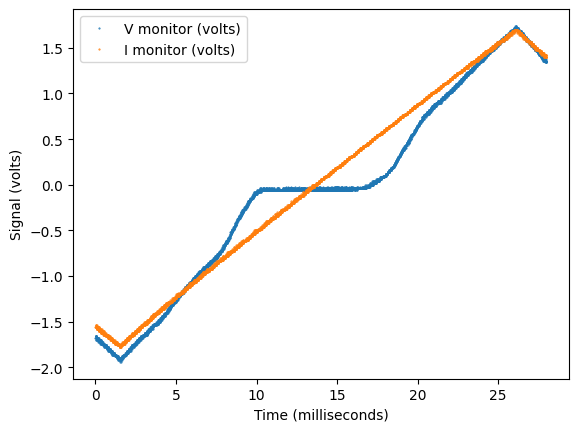

In [11]:
### set up figure with two axes
# fig1=plt.figure(num=1, figsize=(10,4))
# fig1.clf()
# ax1=fig1.add_subplot(121)
# ax2=fig1.add_subplot(122)
# fig1.text (0.4,0.96, "IVC characteristic")

### plot raw data on axis 1
plt.plot(df["time (ms)"], df["ch1"], '.', color ='C0', markersize=1, label='V monitor (volts)')
plt.plot(df["time (ms)"], df["ch2"], '.', color ='C1', markersize=1, label='I monitor (volts)')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Signal (volts)')
plt.legend()
plt.savefig('IVC_signal.png', dpi=300)

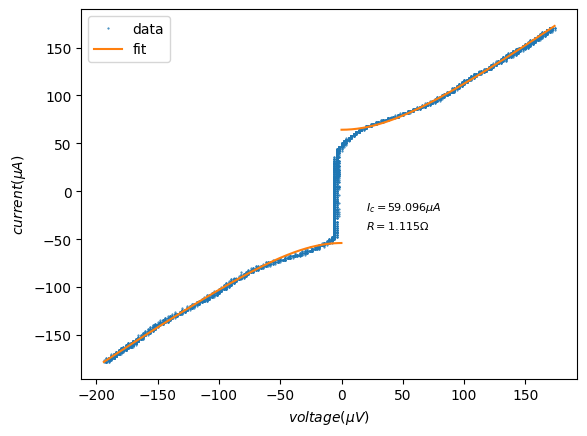

In [12]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 8,
        }

## plot the raw data and the fit
plt.plot(df["V_s (uV)"], df["I (uA)"], '.', markersize=1, label='data', color='C0')
plt.plot(fit_r, IVC_r(fit_r, params_r[0], params_r[1]), label='fit', color='C1')
plt.plot(fit_l, IVC_l(fit_l, params_l[0], params_l[1]), color='C1')
plt.text(20, -20, r"$ I_c = {:.3f} \mu A$".format(I_c), fontdict=font)
plt.text(20, -40, r"$ R = {:.3f} \Omega $".format(R), fontdict=font)
plt.xlabel(r'$voltage (\mu V)$')
plt.ylabel(r'$current (\mu A)$')
plt.legend()
# fig1.canvas.draw()
plt.savefig('IVC.png', dpi=300)